# 0.0 General Area

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

import math 
import inflection
import datetime
import pickle

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

## 0.2 Load Data

In [2]:
# reading data
df_train_raw = pd.read_csv ( '../data/train_raw.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store_raw.csv', low_memory= False )

# merging datasets train and store
df_train_raw = pd.merge( df_train_raw, df_store_raw, how='left', on='Store')
print(f'Train Dimension: rows: { df_train_raw.shape[0] }  cols:  { df_train_raw.shape[1] } ' )


Train Dimension: rows: 1017209  cols:  18 


## 0.3 Support Functions

In [3]:

def data_cleaning( df ):

    # ***** RENAME COLUMNS *****

    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new


    # ***** FILLOUT NA VALUES *****

    # competition_distance with NA values means "no competitor around". Set max value = 200000
    max_value = df['competition_distance'].max()
    df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

    # competition_open_since_month and competition_open_since_year 
    # Set month and year of sale as default value
    df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    df['competition_open_since_year']  = df.apply( lambda x: x['date'].year if math.isnan(  x['competition_open_since_year'] )  else x['competition_open_since_year'], axis=1 )

    # promo2_since_week  and promo2_since_year
    # Set month and year of sale as default value
    df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # promo_interval  - first, create a new column(month_map) with the month of sale  
    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df['promo_interval'].fillna( 0, inplace=True )
    df['month_map'] = df['date'].dt.month.map( month_map )

    # promo_inteval - second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

    # ***** CHANGE DATA TYPES *****

    df['competition_open_since_month']  = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year']   = df['competition_open_since_year'].astype( int )
    df['promo2_since_week']             = df['promo2_since_week'].astype( int )
    df['promo2_since_year']             = df['promo2_since_year'].astype( int )

    return df

def feature_engineering( df ):
    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

    # year week
    df['year_week'] = df.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

    # from competition_open_since columns
    df['competition_since']      = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df['competition_time_month'] = df.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

    # from promo2_since
    df['promo2_since']     = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo2_since']     = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo2_time_week'] = df.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

    #  describes an assortment level: a = basic, b = extra, c = extended
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

    # Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    # a = public holiday, b = easter holiday, c = christmas, 0 = regular day
    df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

    # remove lines where there are no sales 
    df = df[ ( df['open'] != 0 ) & ( df['sales'] > 0 ) ]

    # customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
    # open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
    # sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
    # colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map
    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df = df.drop( cols_drop, axis=1 )

    return df

def data_preparation( df, df_type ):

    # Apply MinMaxScaler - promo2_time_week
    mms = MinMaxScaler()
    df['promo2_time_week'] = mms.fit_transform( df[['promo2_time_week']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

    # Apply MinMaxScaler - year
    mms = MinMaxScaler()
    df['year'] = mms.fit_transform( df[['year']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_distance
    rs = RobustScaler()
    df['competition_distance'] = rs.fit_transform( df[['competition_distance']].values )
    if df_type == 'train':    
        pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_time_month
    rs = RobustScaler()
    df['competition_time_month'] = rs.fit_transform( df[['competition_time_month']].values )
    if df_type == 'train':
        pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

    # Apply One-Hot Encoding - state_holiday
    df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )     

    # Apply Label Encoding - store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform( df['store_type'])
    if df_type == 'train':
        pickle.dump( le, open( '../parameters/store_type_scaler.pkl', 'wb' ) )       

    # Apply Ordinal Encoding - assortment
    assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
    df['assortment'] = df['assortment'].map( assortment_dict )

    # Apply Logarithm Transformation - response variable (sales)
    df['sales'] = np.log1p( df['sales'] ) 

    # Calculate sin and cos - month - variable with cyclic behavior
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

    # Calculate sin and cos - day_of_week - variable with cyclic behavior
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

    # Calculate sin and cos - day - variable with cyclic behavior
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

    # Calculate sin and cos - week_of_year - variable with cyclic behavior
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )
    
    return df

# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )


## 0.4 Split Raw Train Dataframe in two: training and test( last 6 weeks )

In [4]:
# change data type - date column
df_train_raw['Date'] = pd.to_datetime( df_train_raw['Date'] )

# calculate period - last 6  weeks
last_date  = df_train_raw[['Store', 'Date']].groupby( 'Store' ).max().reset_index().loc[0, 'Date']
first_date = last_date - datetime.timedelta( days=6*7 )

# creating train and test datasets
df_train = df_train_raw.copy() 
df_test  = df_train_raw.copy() 

df_train = df_train[ df_train['Date'] <= first_date ]
df_test  = df_test[  df_test['Date'] > first_date ]

print(f'First date Train: { df_train["Date"].min() } ')
print(f'Last date Train : { df_train["Date"].max() } ')

print(f'\nFirst date Test: { df_test["Date"].min() } ')
print(f'Last date Test :   { df_test["Date"].max() } ')

First date Train: 2013-01-01 00:00:00 
Last date Train : 2015-06-19 00:00:00 

First date Test: 2015-06-20 00:00:00 
Last date Test :   2015-07-31 00:00:00 


# 1.0 Data Cleaning

In [5]:
df1 = data_cleaning( df_train.copy() )

## 1.1 Columns

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 970379
Number of Cols: 20


## 1.3 Data Types

In [8]:
# list data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.4 Check NA

In [10]:
# number of rows with NA values by column
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
46830,1,5,2015-06-19,4202,487,1,1,0,0,c,a,1270.0,9,2008,0,25,2015,0,Jun,0
46831,2,5,2015-06-19,4926,544,1,1,0,0,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jun,0
46832,3,5,2015-06-19,8074,797,1,1,0,0,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jun,0
46833,4,5,2015-06-19,9686,1281,1,1,0,0,c,c,620.0,9,2009,0,25,2015,0,Jun,0
46834,5,5,2015-06-19,5711,610,1,1,0,0,a,a,29910.0,4,2015,0,25,2015,0,Jun,0


## 1.6 Data Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [13]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
403924,0,d,c,"Jan,Apr,Jul,Oct",Jul
904384,0,a,a,0,Apr


### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.450465,558.0,321.910208,-0.001001,-1.200549
1,day_of_week,1.0,7.0,6.0,3.998260,4.0,1.997264,0.001670,-1.246722
2,sales,0.0,38722.0,38722.0,5762.766017,5736.0,3855.455197,0.641891,1.763948
3,customers,0.0,7388.0,7388.0,633.273381,610.0,465.576109,1.587450,7.009617
4,open,0.0,1.0,1.0,0.828656,1.0,0.376810,-1.744415,1.042985
5,promo,0.0,1.0,1.0,0.382691,0.0,0.486044,0.482712,-1.766993
6,school_holiday,0.0,1.0,1.0,0.173512,0.0,0.378689,1.724312,0.973253
7,competition_distance,20.0,200000.0,199980.0,5935.778917,2330.0,12542.489994,10.239047,147.781841
8,competition_open_since_month,1.0,12.0,11.0,6.773174,7.0,3.338177,-0.037770,-1.257515
9,competition_open_since_year,1900.0,2015.0,115.0,2010.307752,2012.0,5.495594,-7.252592,124.657560


### 1.7.2 Categorical Attributes

In [15]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

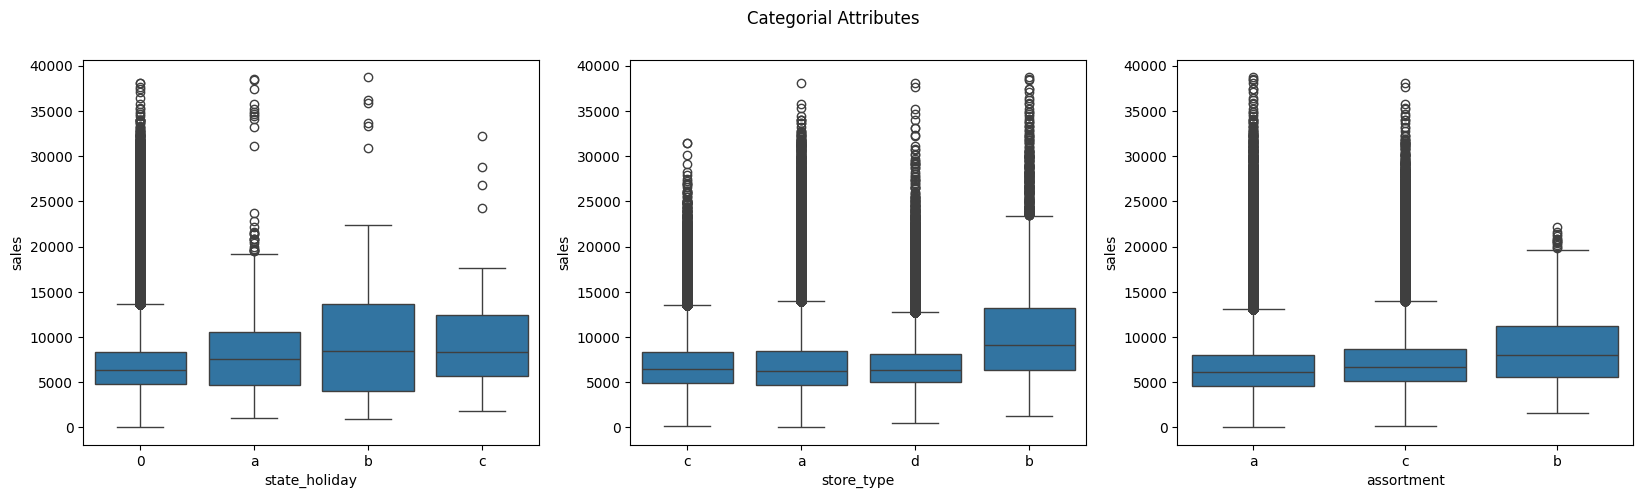

In [16]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [17]:
df2 = feature_engineering( df1.copy() )

## 2.1 Hypothesis Mind Map

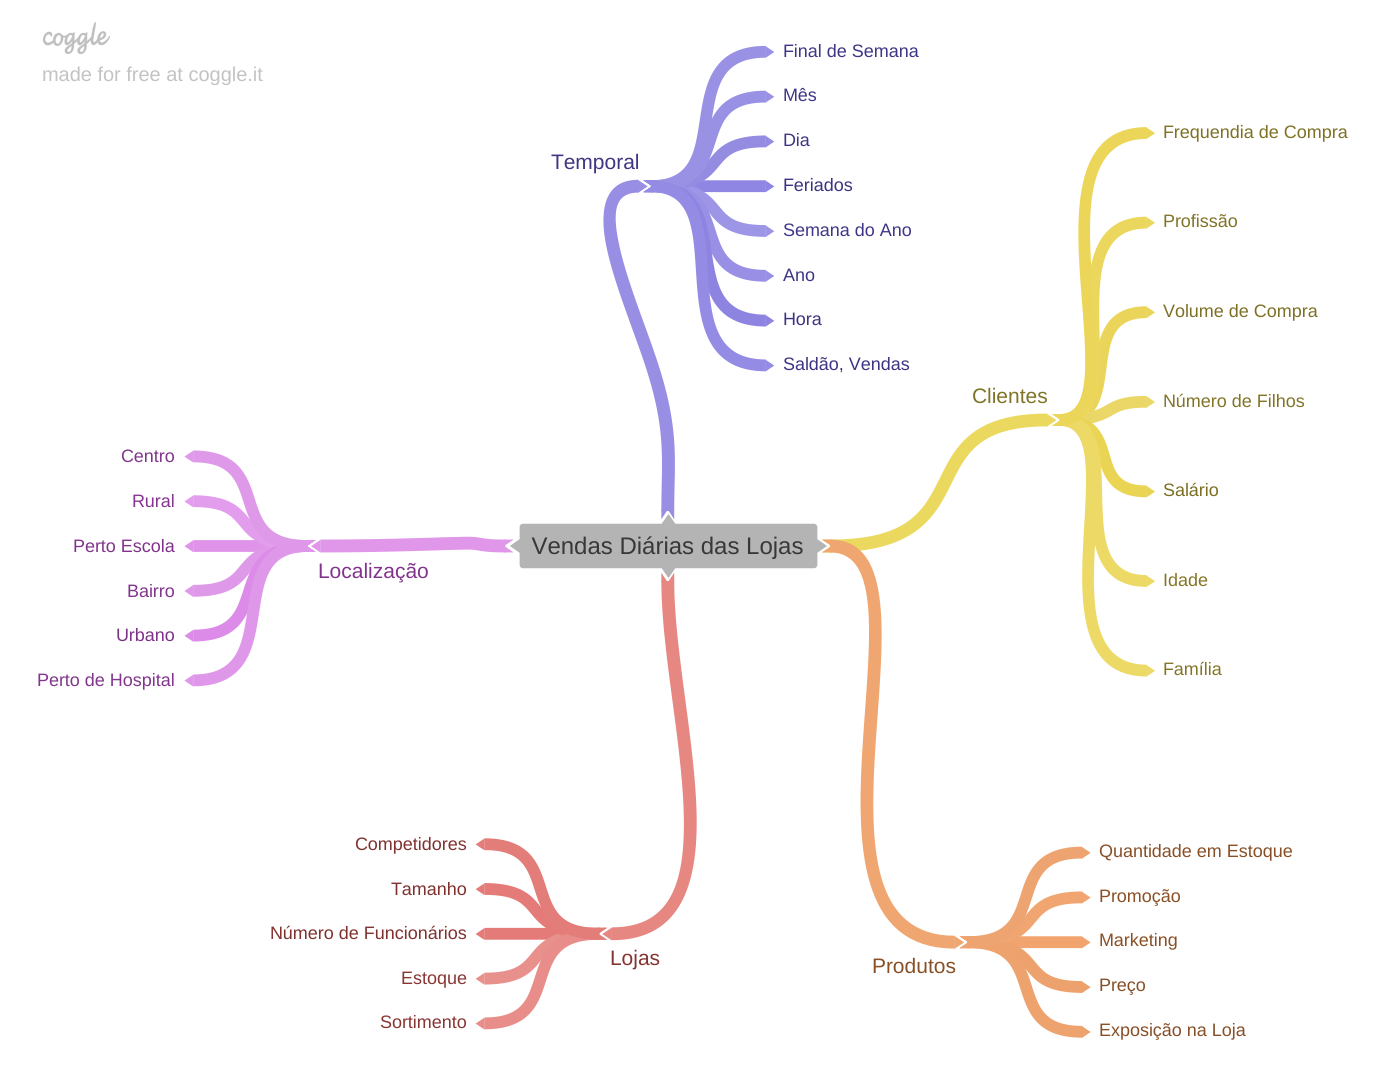

In [18]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

### 2.4.1 From date column

In [19]:
df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
719935,2013-09-24,2013,9,24,39,2013-39
451911,2014-05-22,2014,5,22,21,2014-21
771455,2013-08-09,2013,8,9,32,2013-32
337081,2014-09-15,2014,9,15,38,2014-38
649899,2013-11-26,2013,11,26,48,2013-48


### 2.4.2 From competition_open_since columns

In [20]:
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
856489,2013-05-25,2009,7,2009-07-01,47
474283,2014-05-02,2014,5,2014-05-01,0
650549,2013-11-25,2013,11,2013-11-01,0
828734,2013-06-19,2013,10,2013-10-01,-4
1001755,2013-01-14,2011,2,2011-02-01,23


### 2.4.3 From promo2_since columns

In [21]:
df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
315737,2014,41,2014-10-06,2014-10-08,0
624064,2014,10,2014-03-03,2013-12-19,-11
462114,2014,20,2014-05-12,2014-05-13,0
341413,2009,37,2009-09-07,2014-09-10,261
159353,2015,11,2015-03-09,2015-03-11,0


### 2.4.4 From assorment column

In [22]:
df2['assortment'].value_counts()

assortment
basic       423516
extended    372709
extra         7831
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [23]:
df2['state_holiday'].value_counts()

state_holiday
regular day       803146
public holiday       694
easter holiday       145
christmas             71
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [24]:
df2.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
747462,83,5,2013-08-30,4031,1,regular day,1,a,basic,2710.0,...,0,2013,8,30,35,2013-35,2013-08-01,0,2013-08-26,0
296189,1078,3,2014-10-29,5128,0,regular day,1,d,extended,670.0,...,1,2014,10,29,44,2014-44,2014-10-01,0,2011-09-26,161
679068,819,4,2013-10-31,5723,0,regular day,0,a,extended,720.0,...,0,2013,10,31,44,2013-44,2014-10-01,-12,2013-10-28,0
287639,925,5,2014-11-07,8746,1,regular day,0,c,basic,470.0,...,0,2014,11,7,45,2014-45,2007-03-01,93,2011-12-26,149
513969,740,5,2014-03-28,4974,0,regular day,0,d,basic,6400.0,...,0,2014,3,28,13,2014-13,2014-03-01,0,2014-03-24,0


### 2.5.2 Filtering Columns

In [25]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [26]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

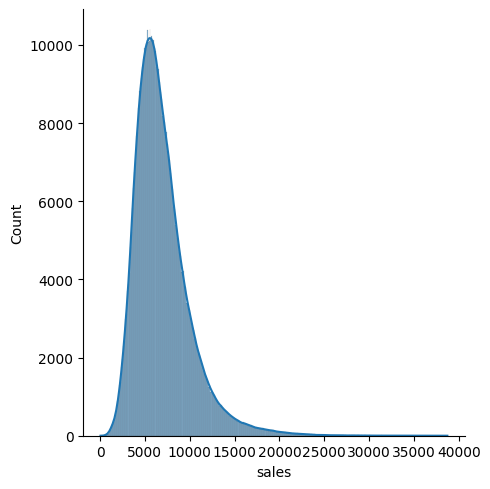

In [27]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

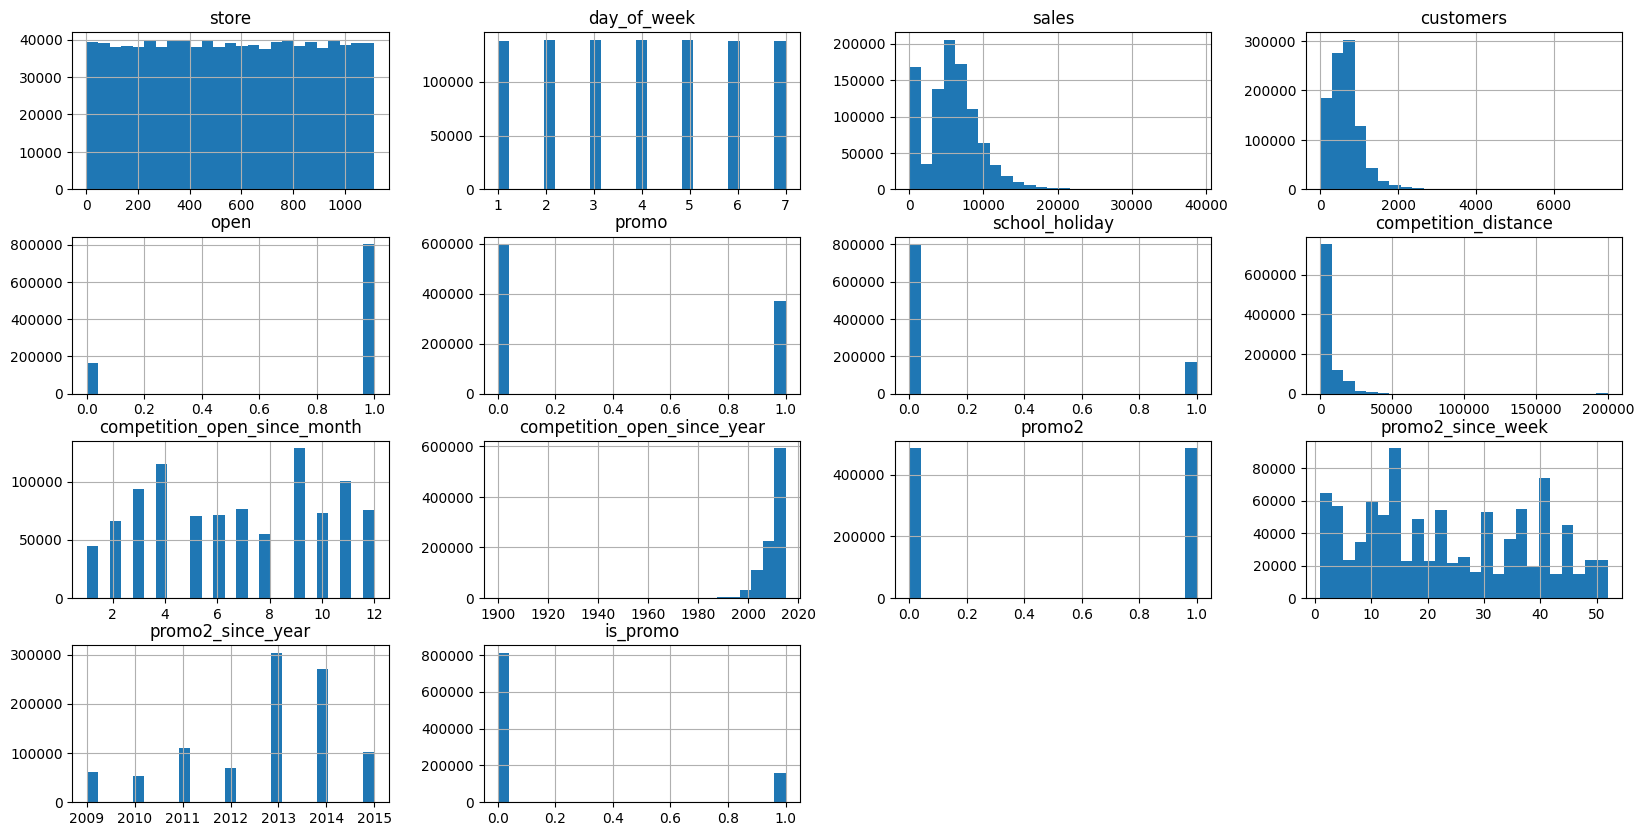

In [28]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

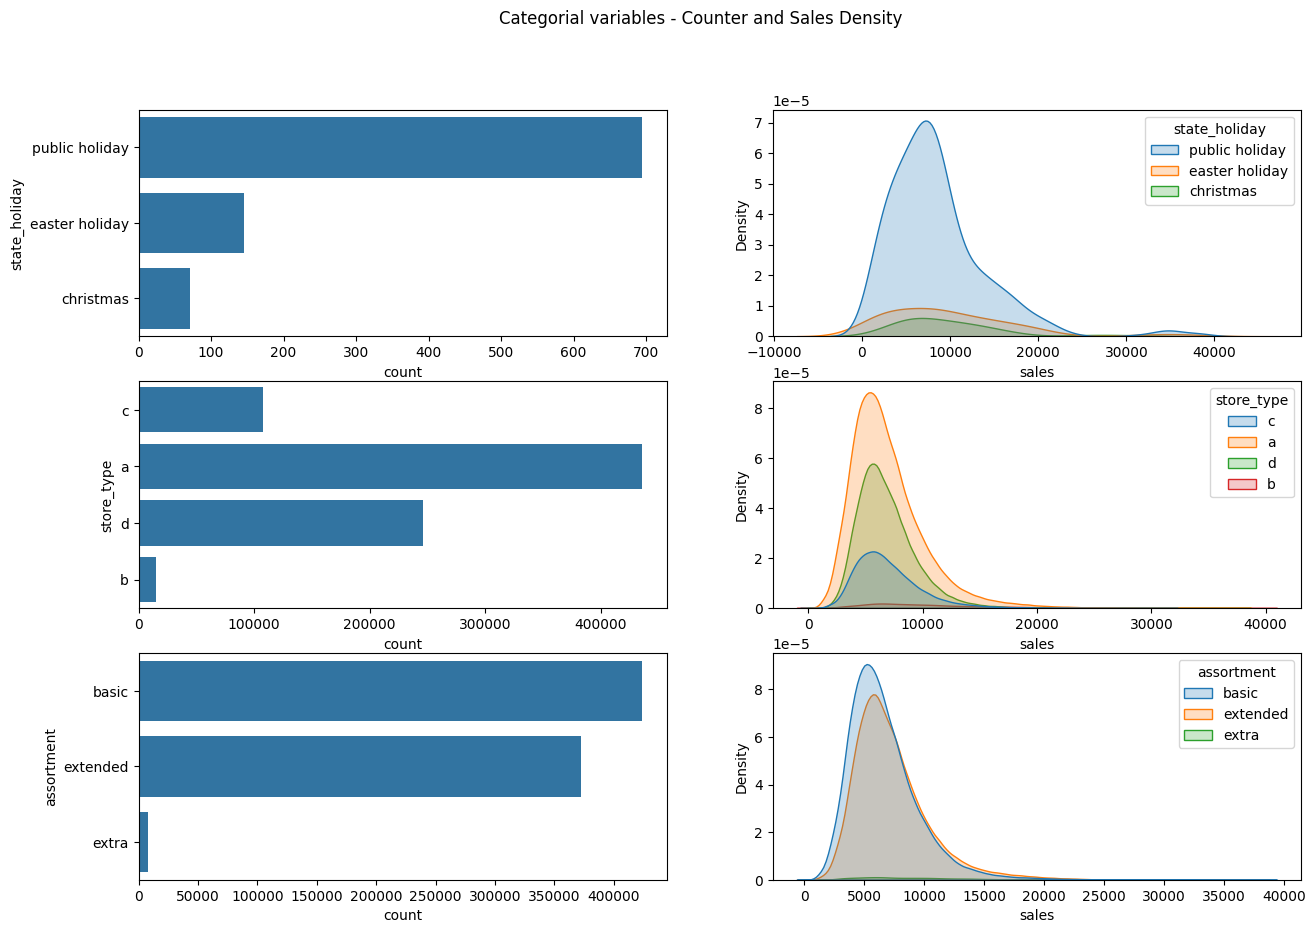

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

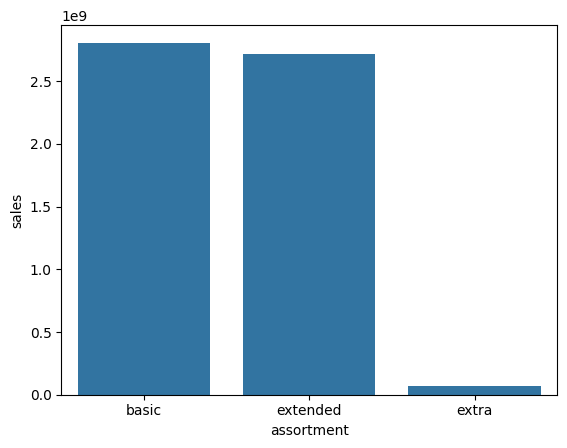

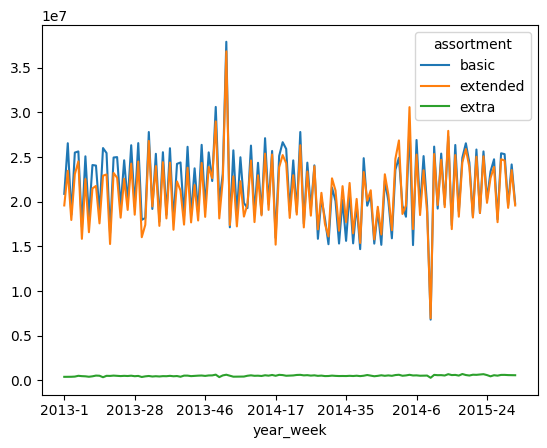

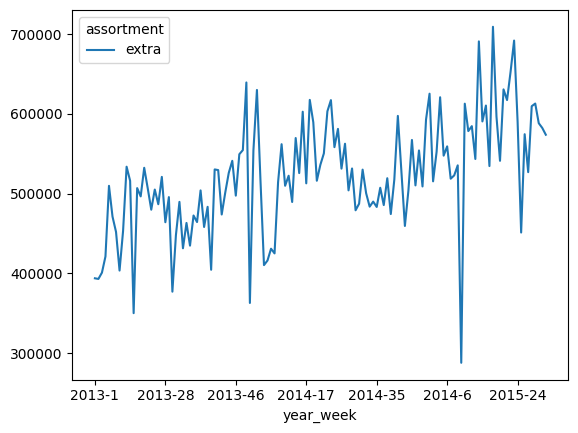

In [30]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

/tmp/ipykernel_45560/3322249751.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()


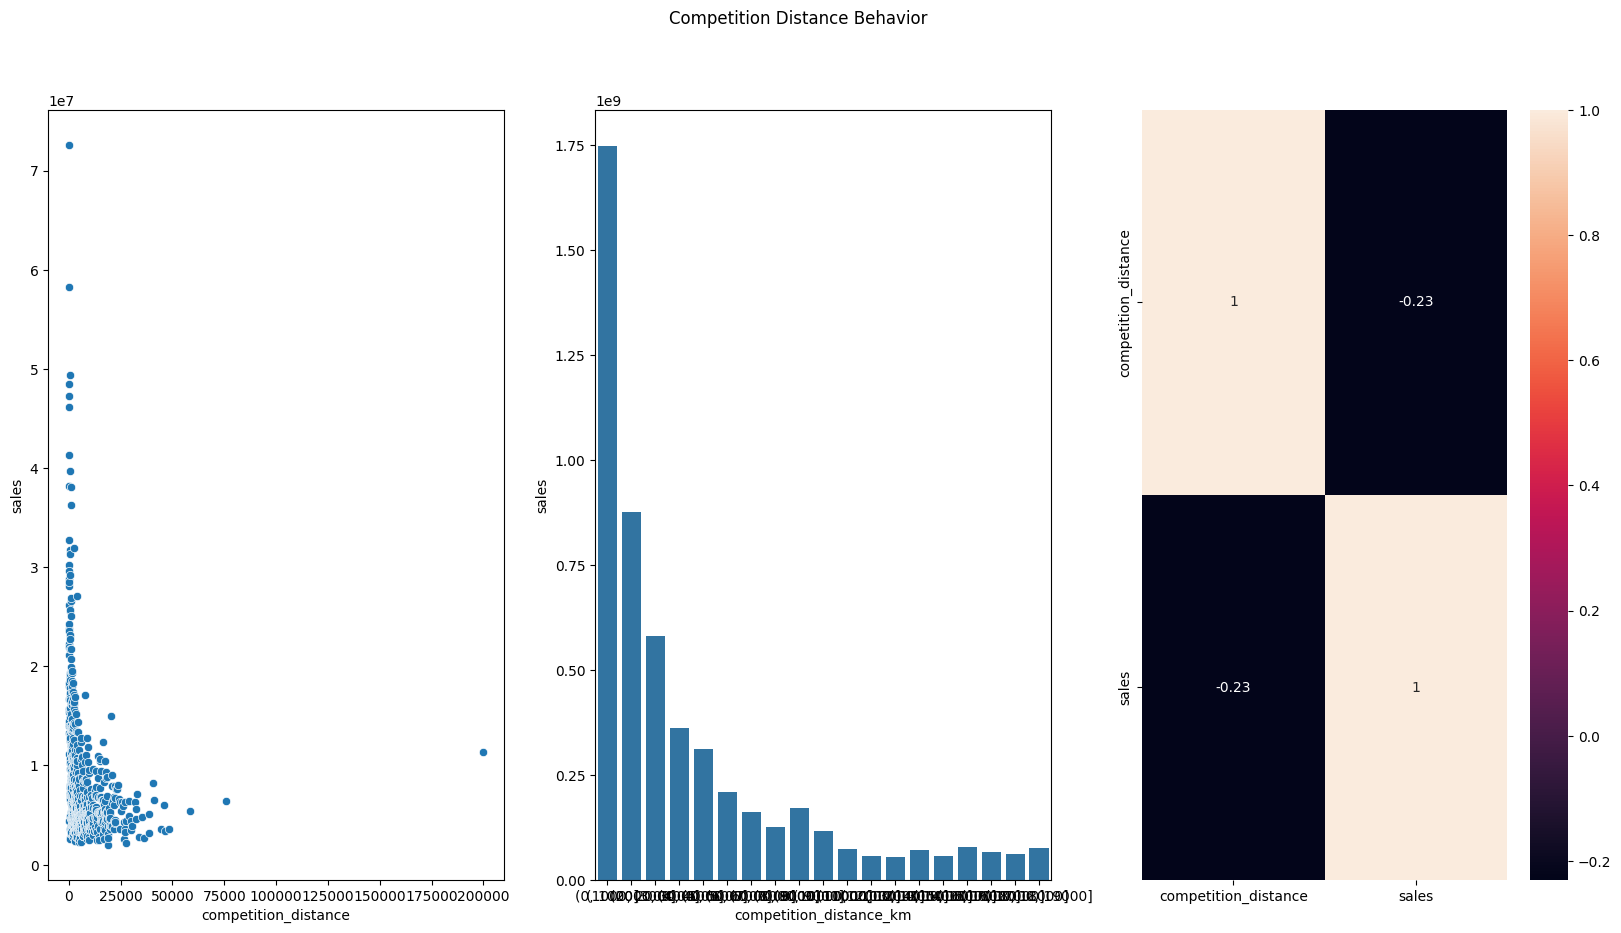

In [31]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

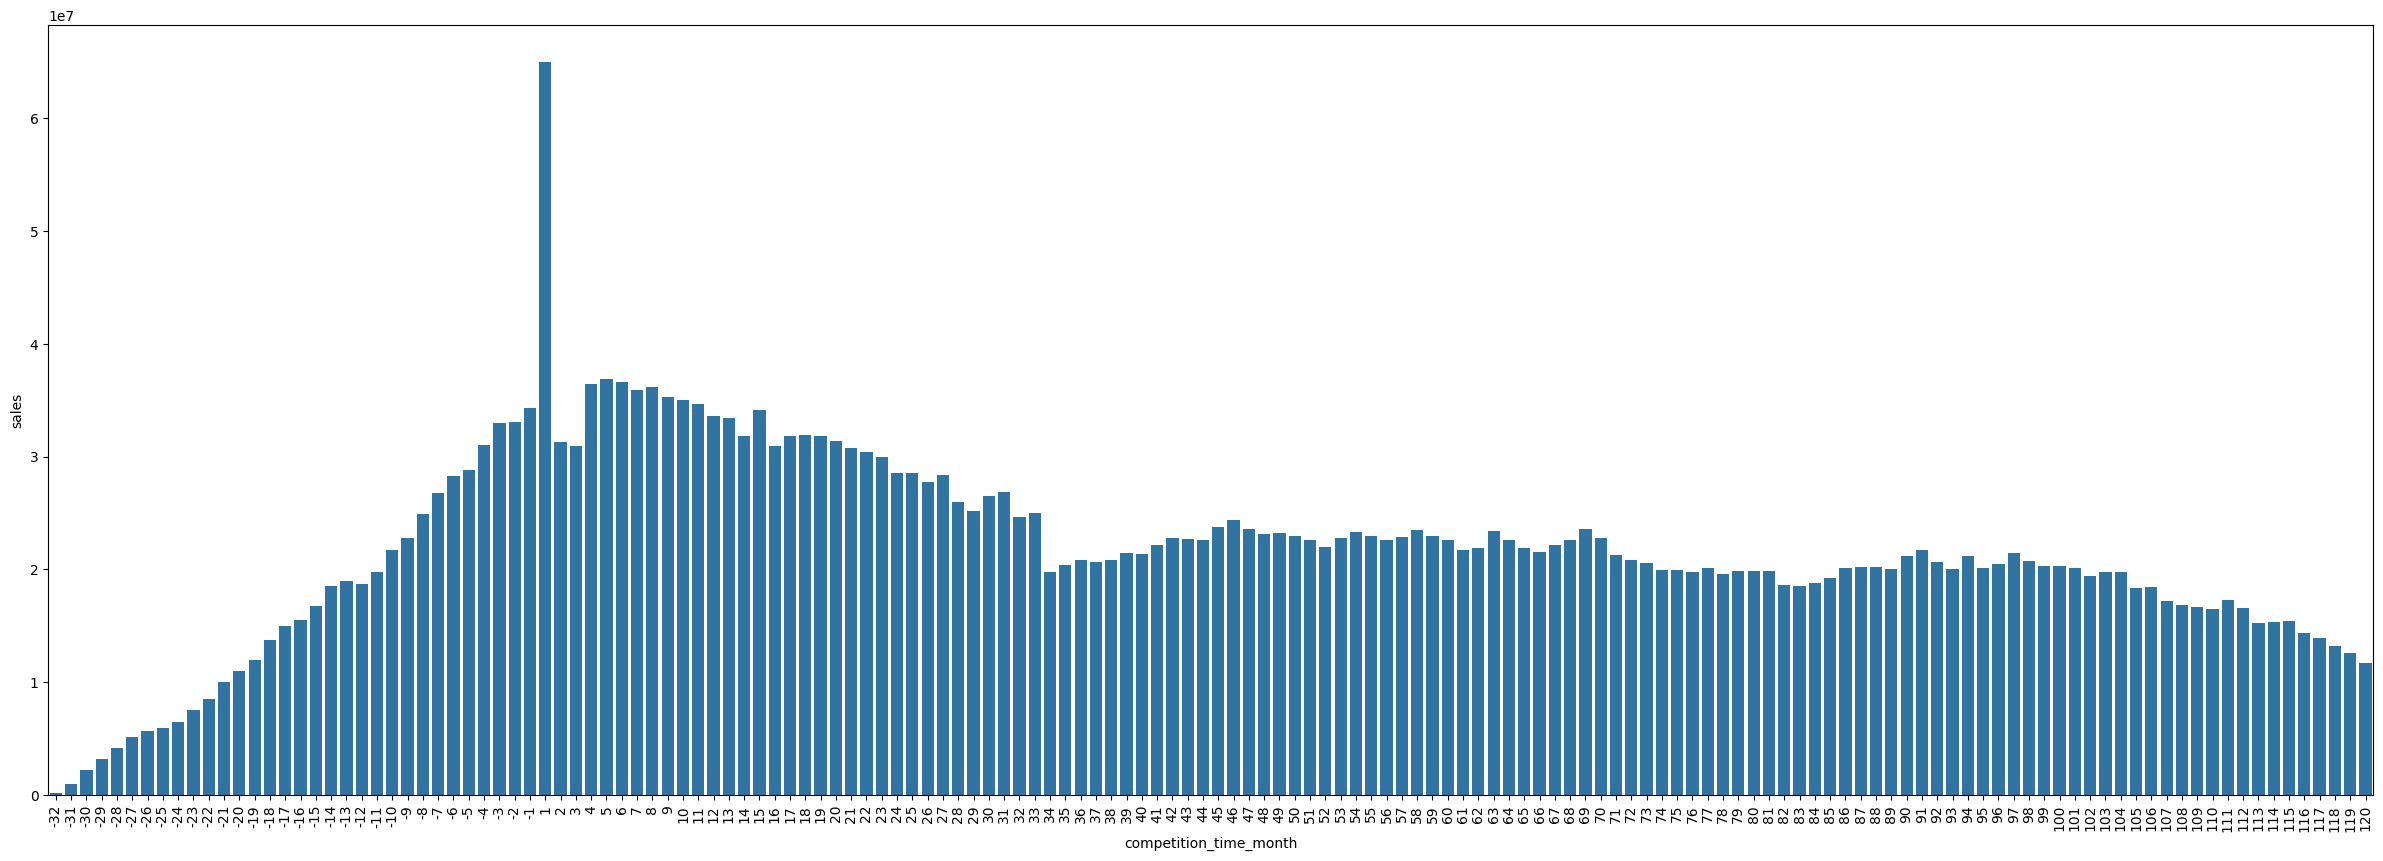

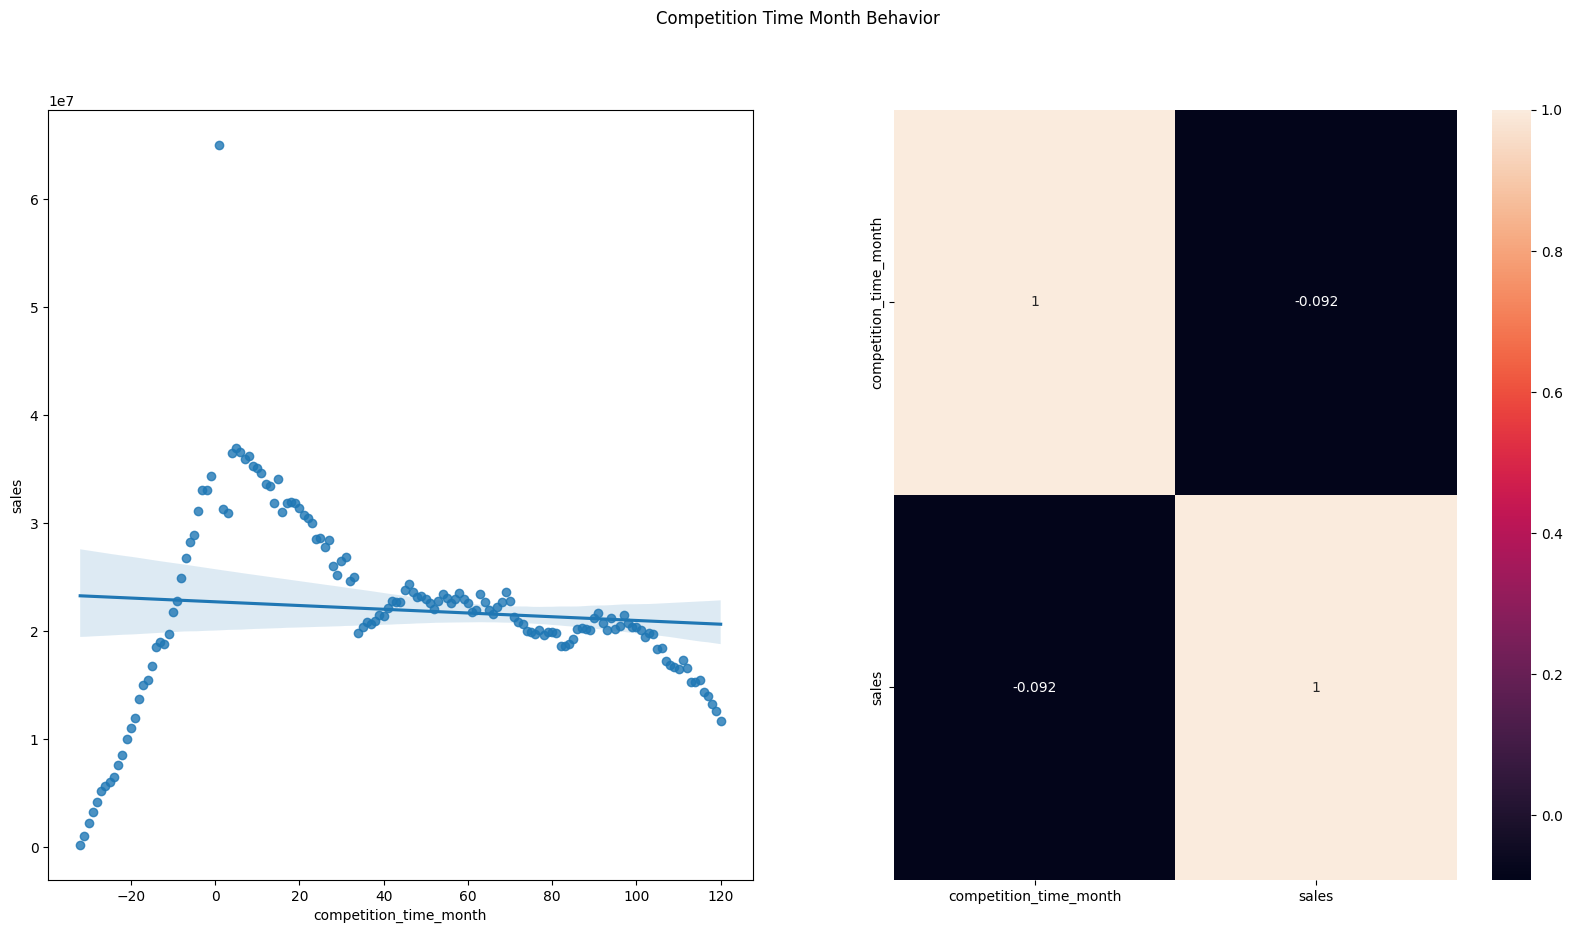

In [32]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

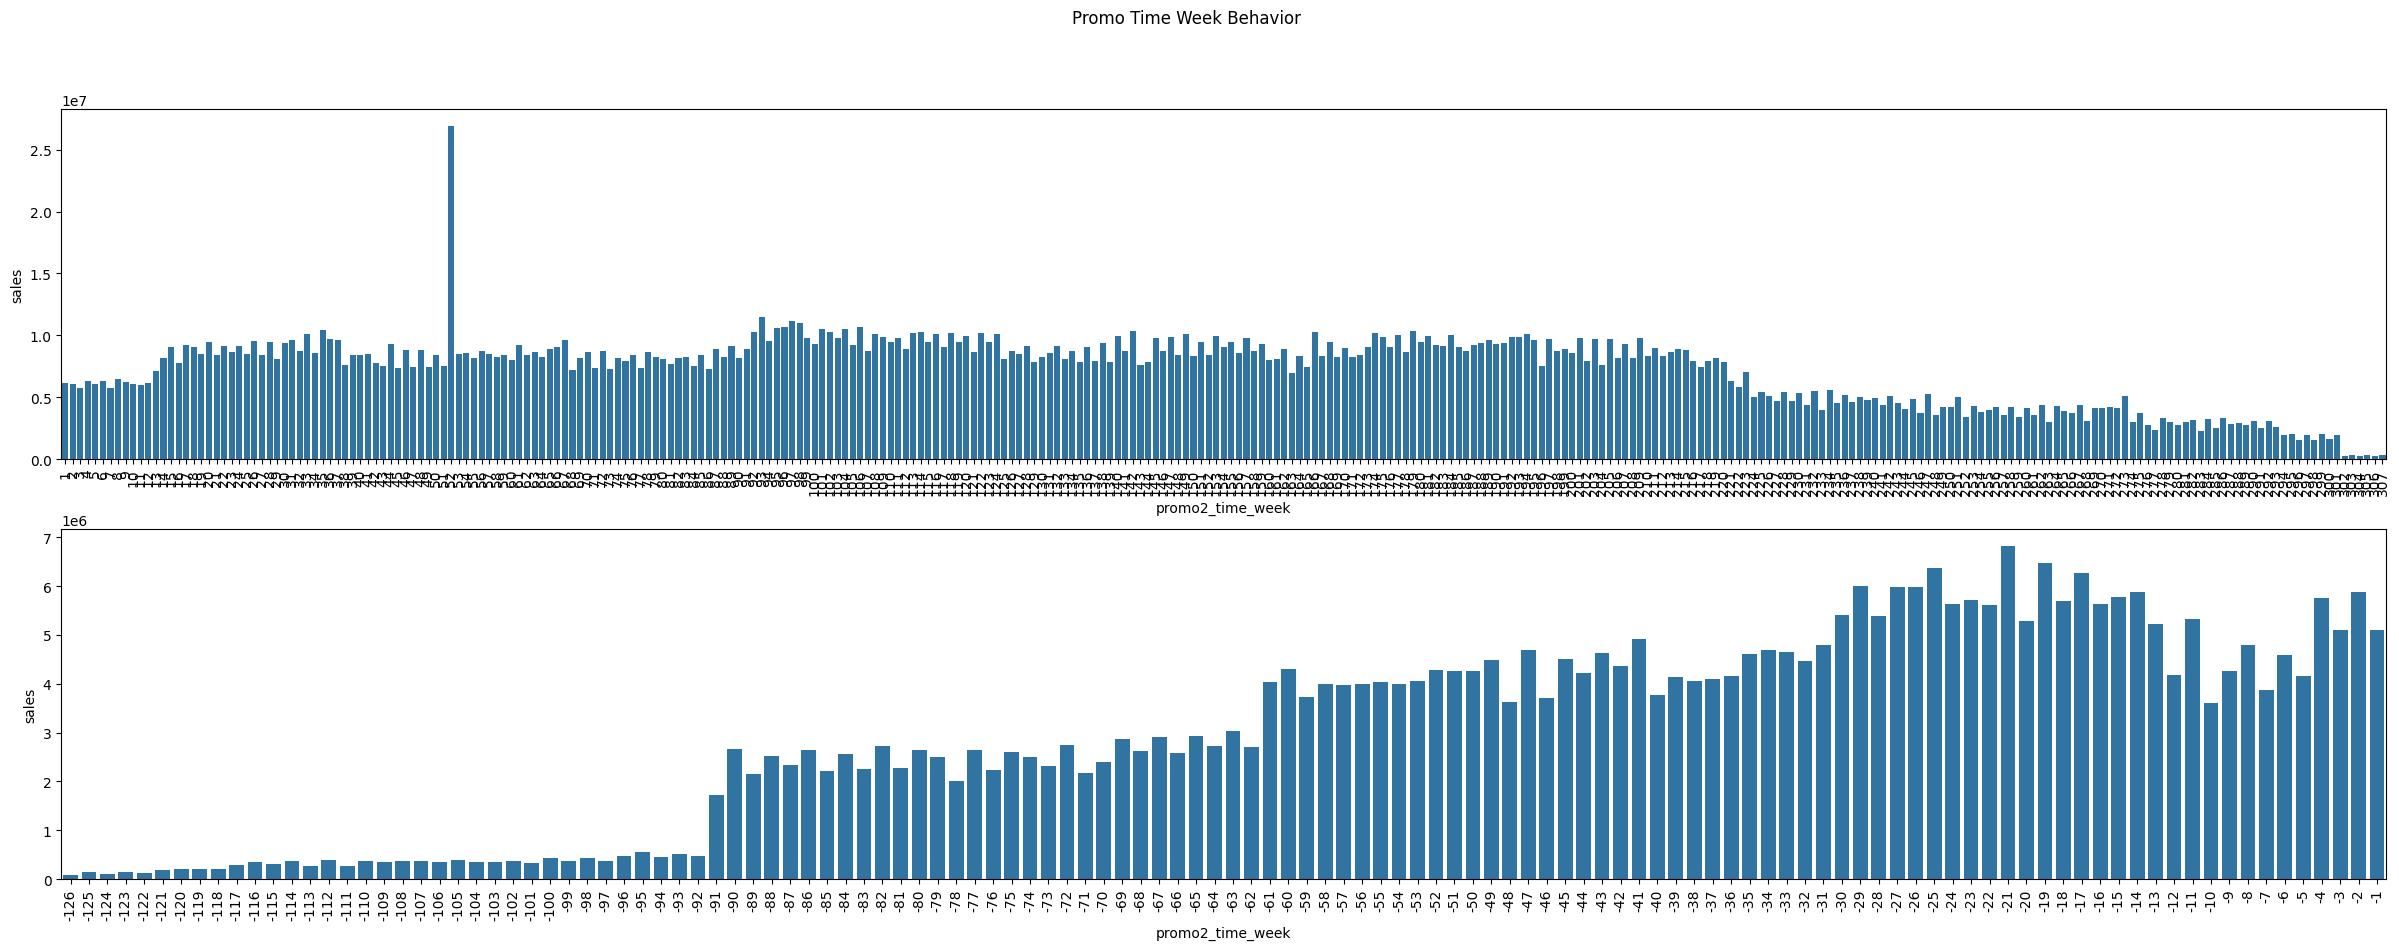

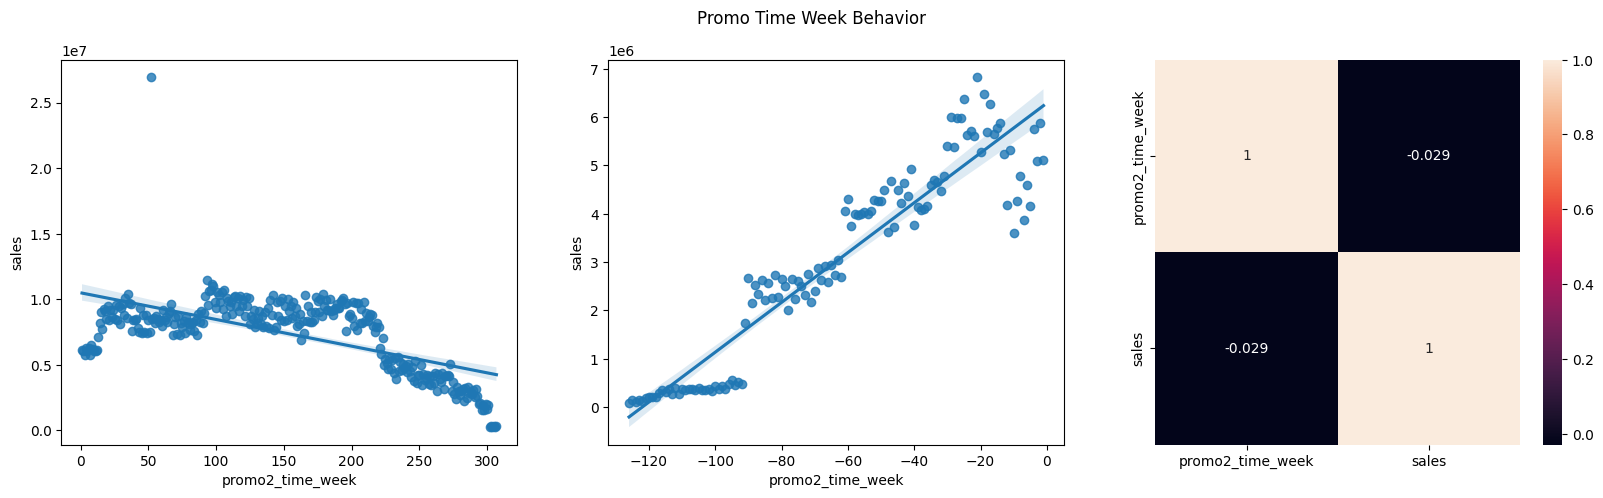

In [33]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

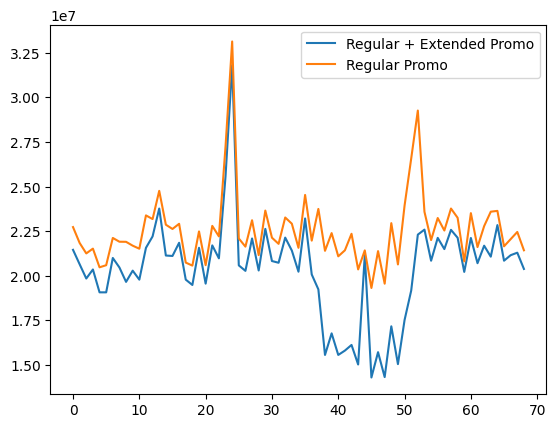

In [34]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

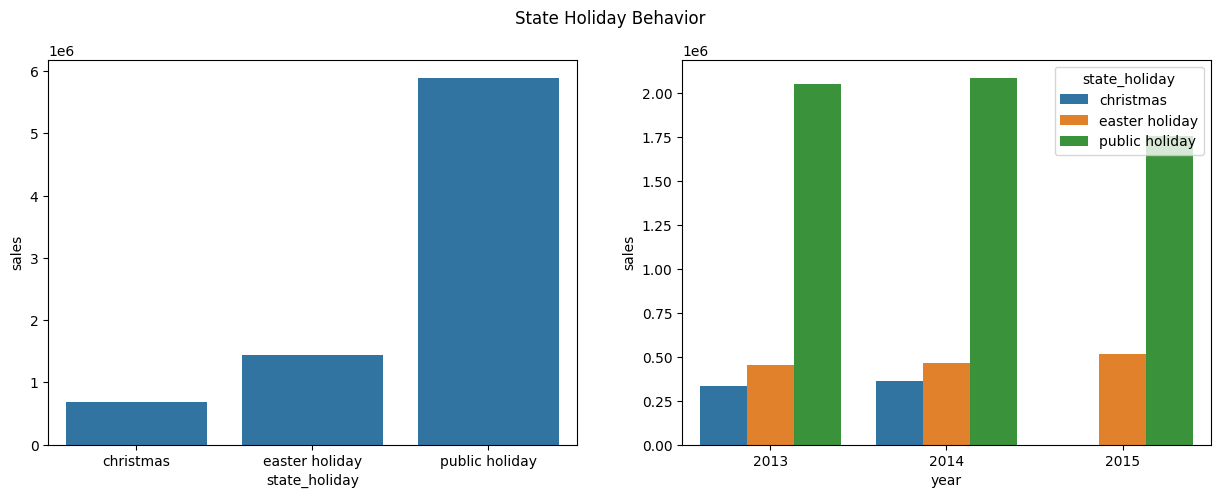

In [35]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

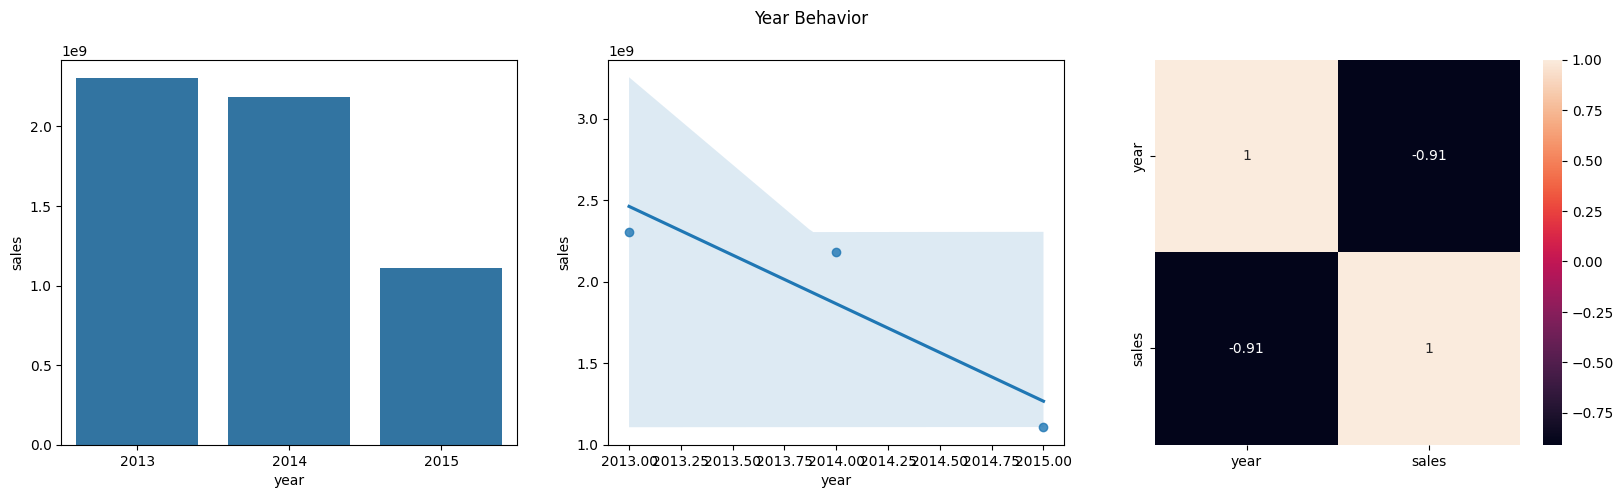

In [36]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

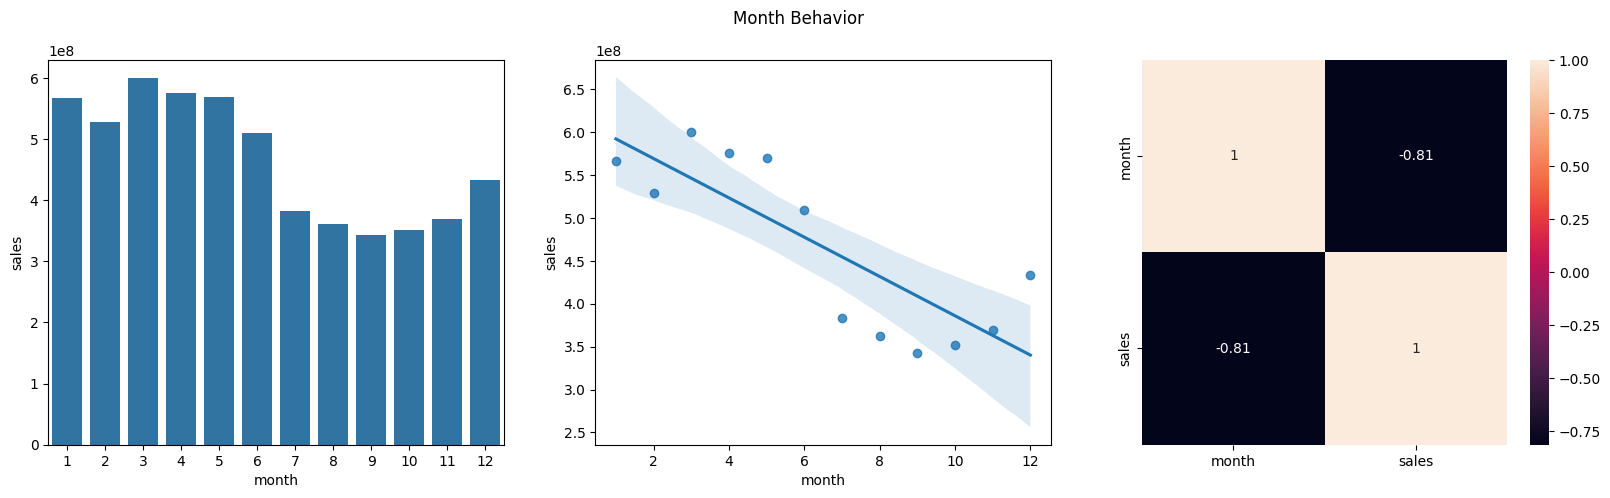

In [37]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

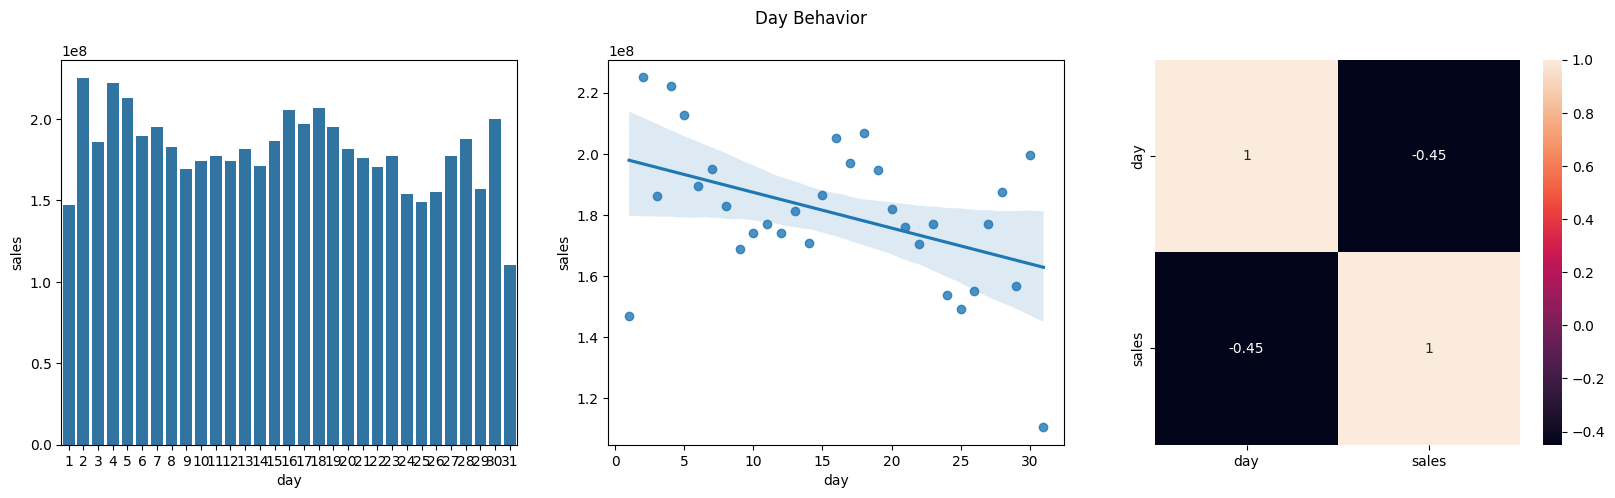

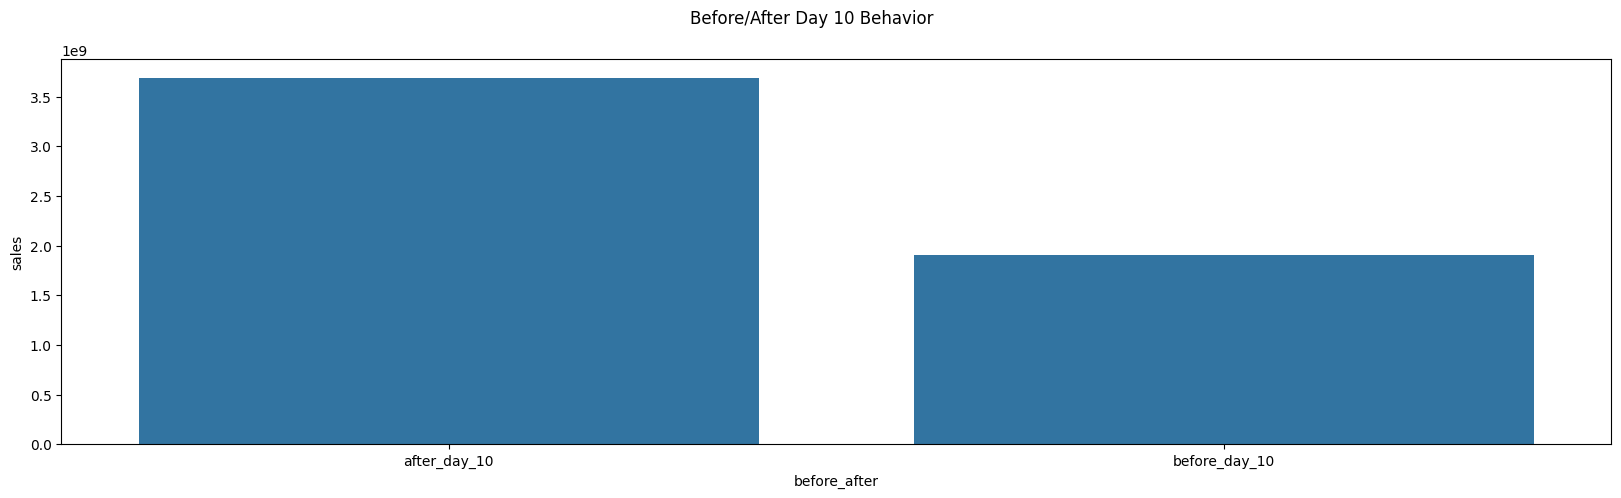

In [38]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

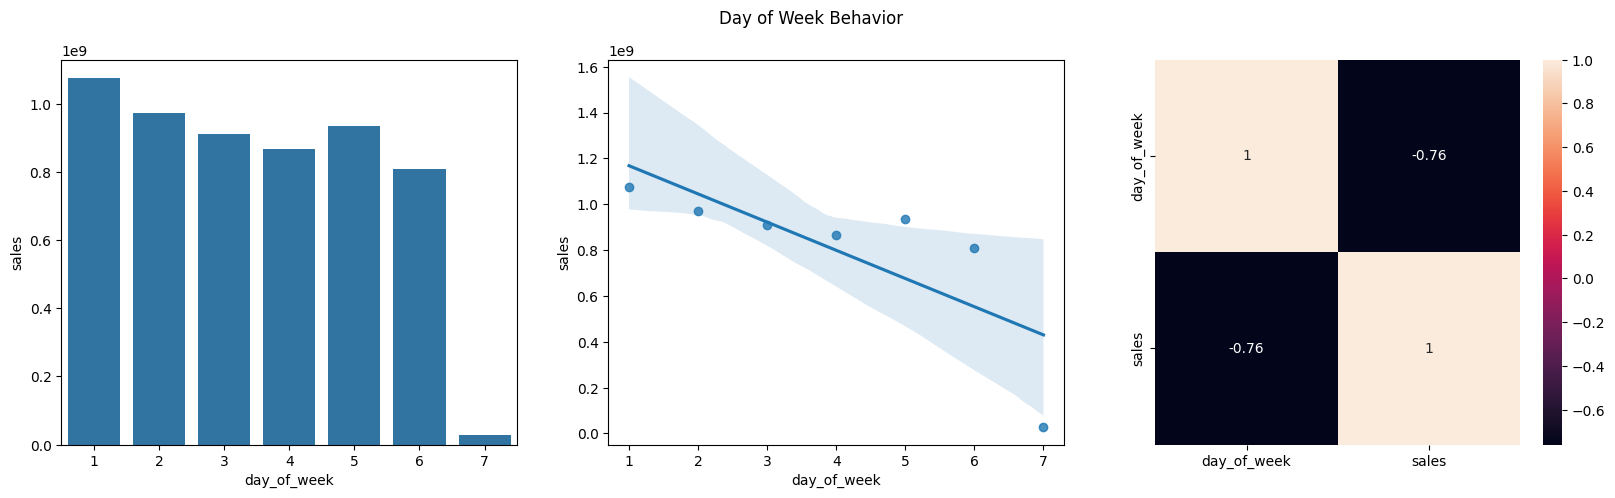

In [39]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

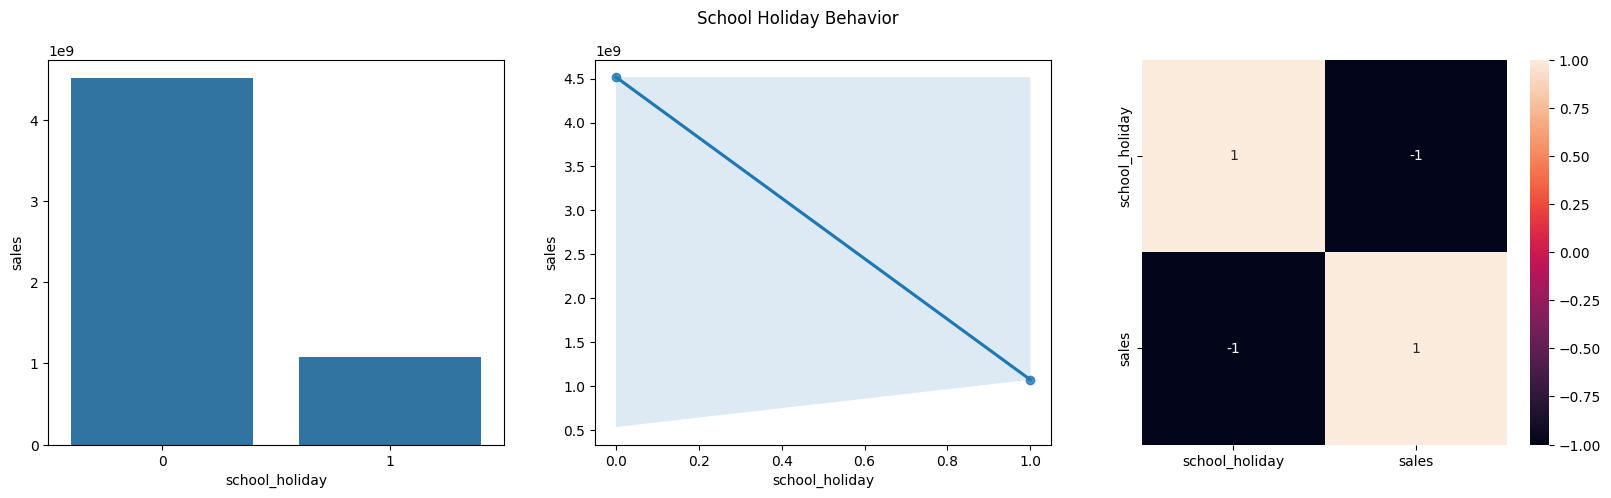

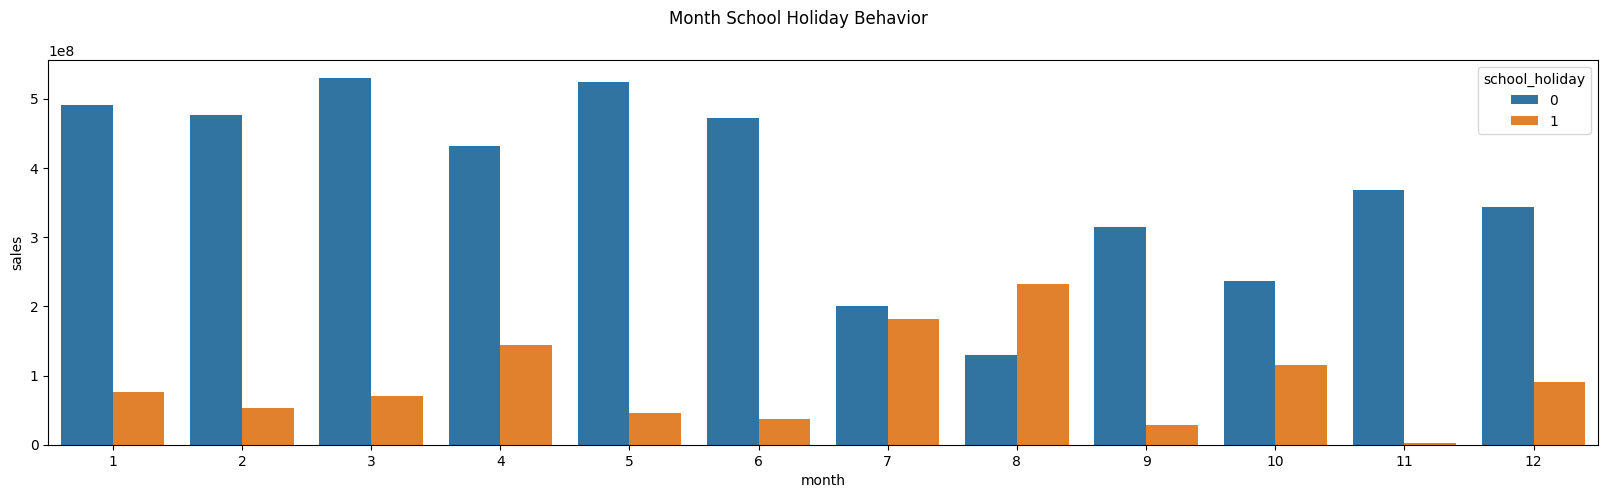

In [40]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [41]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

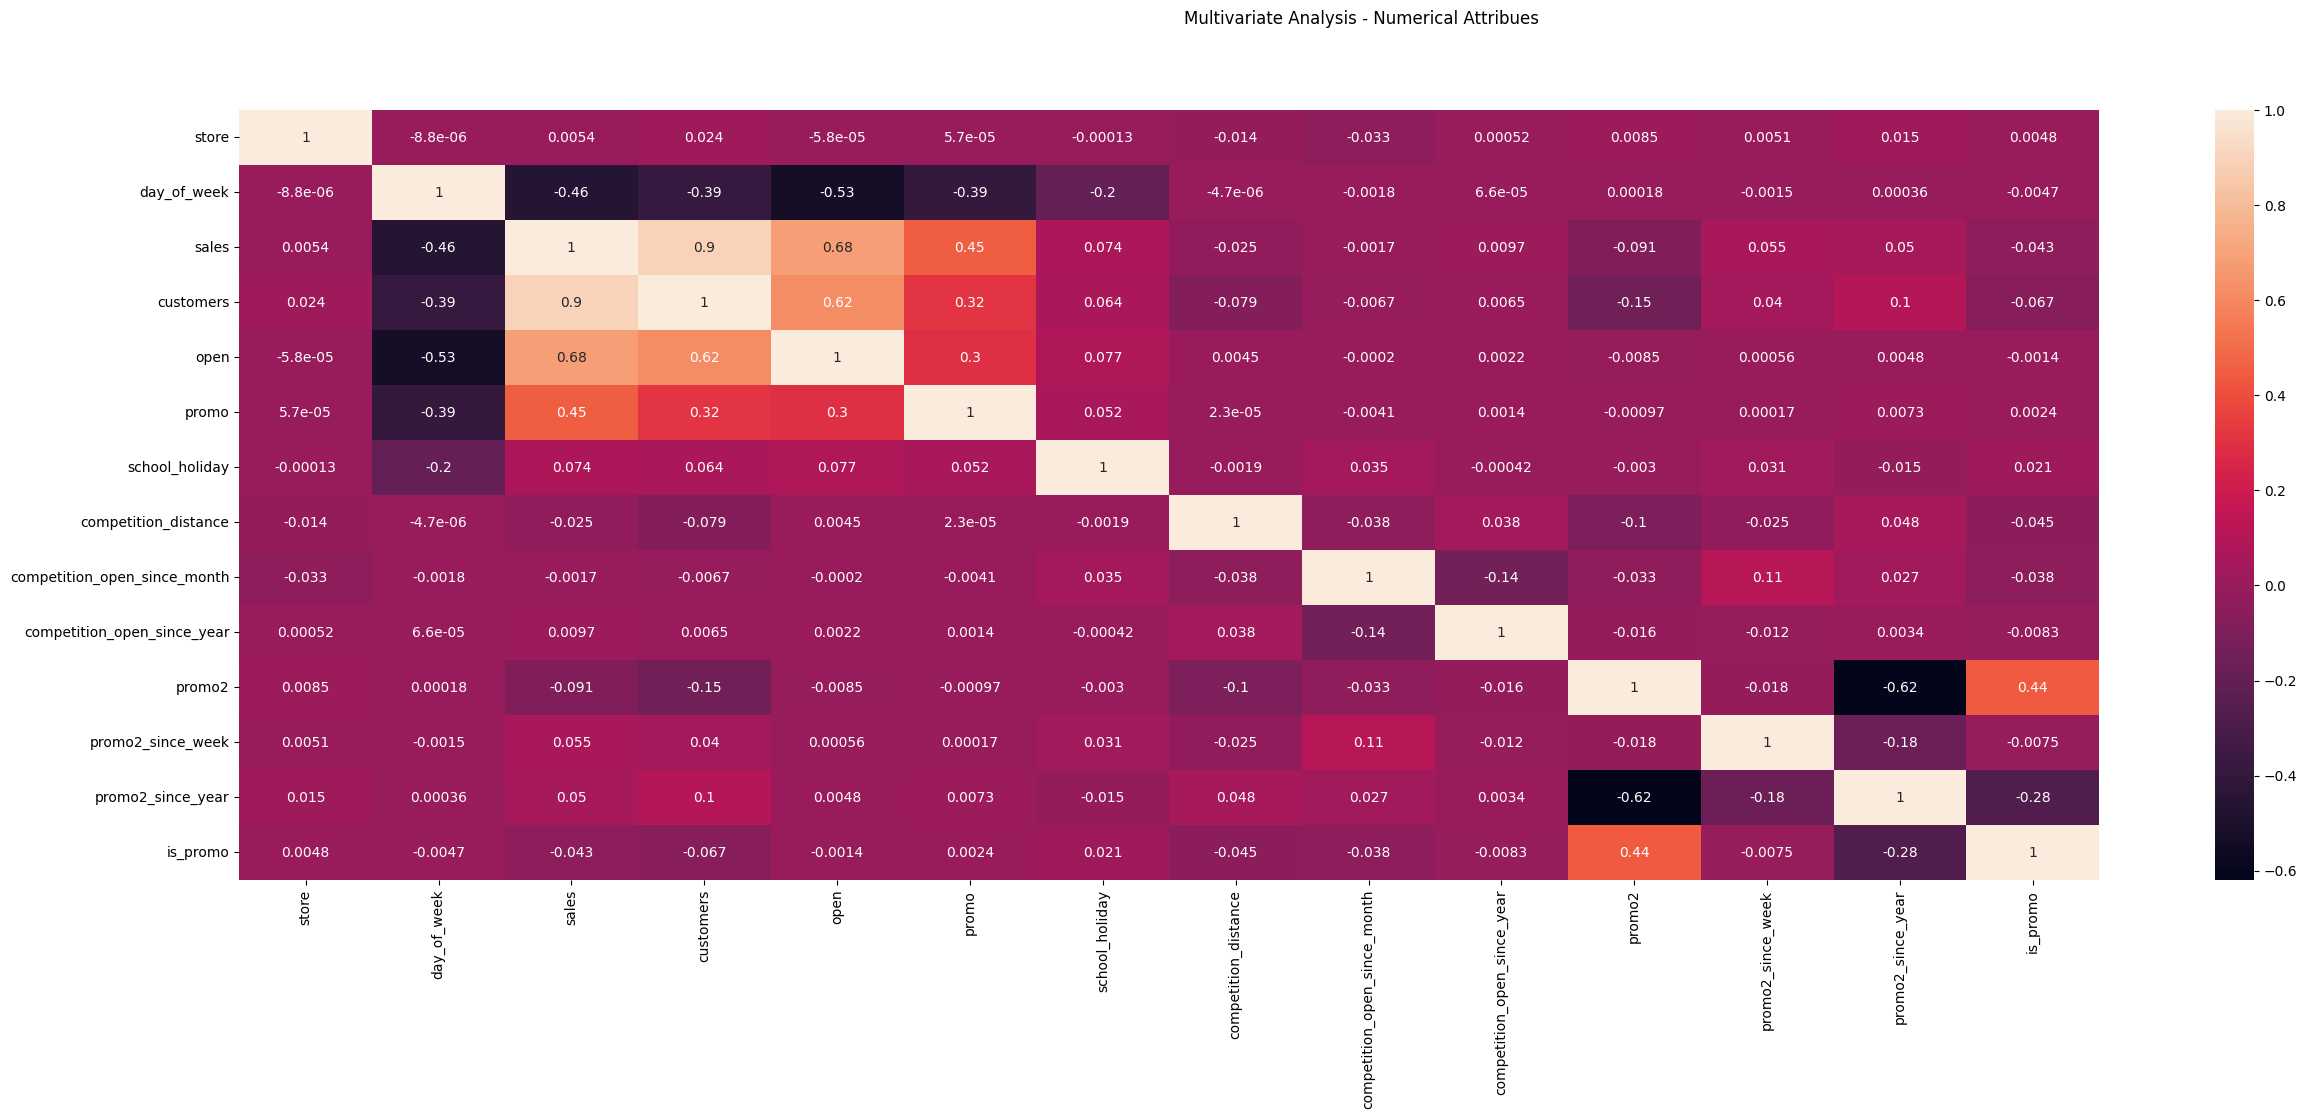

In [42]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [43]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
751713,regular day,a,basic,2013-35
191300,regular day,c,basic,2015-7
607517,regular day,a,extended,2014-1
319329,regular day,d,basic,2014-40
872950,regular day,d,extended,2013-19


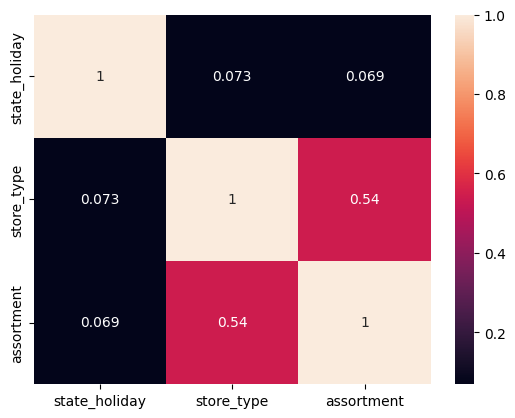

In [44]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [45]:
df4 = data_preparation( df3.copy(), 'train' )

## 4.1 Normalization Method

**COMENTÁRIO:** Ao observar a distribuição das variáveis numéricas (seção 3.1.2), nota-se que NÃO HÁ variáveis com distribuição NORMAL, portanto, não há sentido em executar o método de normalização nesse conjunto de dados

## 4.2 Rescaling Method

### 4.2.1 Min-Max Scaler

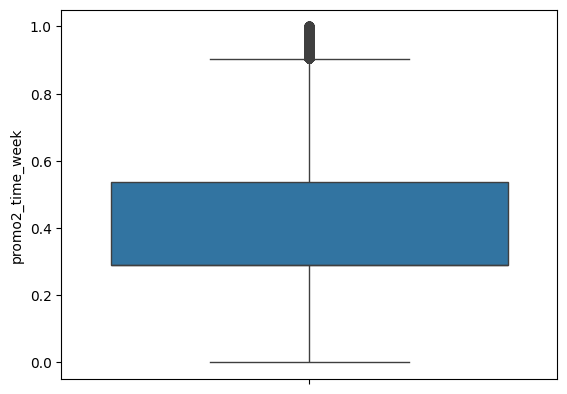

In [46]:
# promo2_time_wee - Few outliers 
sns.boxplot( df4['promo2_time_week'] );

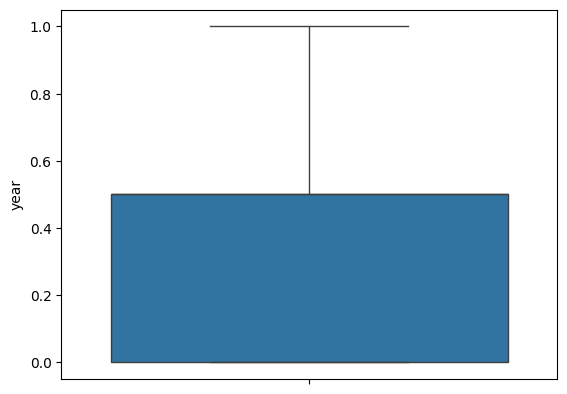

In [47]:

# year - Few outliers 
sns.boxplot( df4['year'] );

### 4.2.2 Robuster Scaler

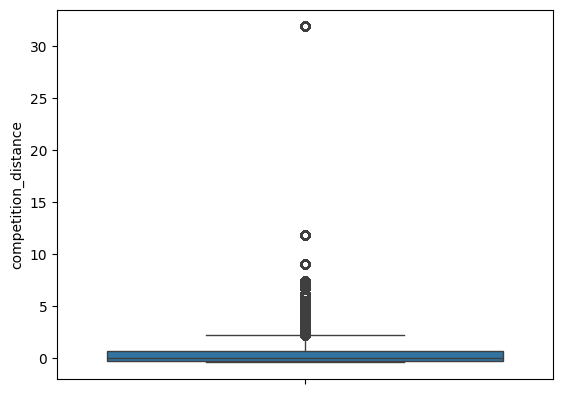

In [48]:
# competition_distance - Many outliers 
sns.boxplot( df4['competition_distance'] );

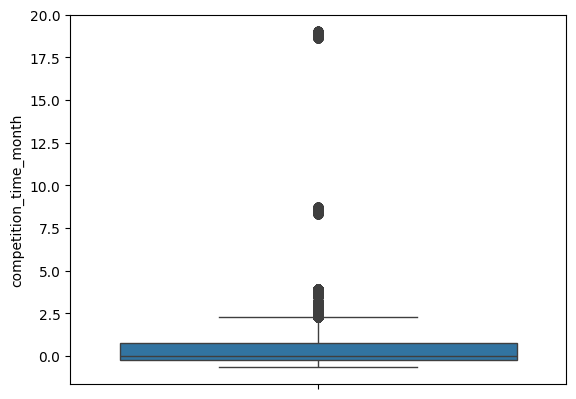

In [49]:
# competition_time_month - Many outliers 
sns.boxplot( df4['competition_time_month'] );

## 4.3 Transformation Method

### 4.3.1 Encoding Transformation

#### state_holiday column

In [50]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
805676,317,2,2013-07-09,8.305978,0,0,3,1,0.130645,7,...,False,True,-5.000000e-01,-0.866025,0.974928,-0.222521,0.951057,-0.309017,-2.393157e-01,-0.970942
180166,652,5,2015-02-20,8.848078,1,0,0,1,2.912903,2,...,False,True,8.660254e-01,0.500000,-0.974928,-0.222521,-0.866025,-0.500000,8.229839e-01,0.568065
822108,24,1,2013-06-24,8.859647,0,0,0,3,0.364516,3,...,False,True,1.224647e-16,-1.000000,0.781831,0.623490,-0.951057,0.309017,1.224647e-16,-1.000000
93881,222,5,2015-05-08,8.719317,1,0,0,1,-0.025806,11,...,False,True,5.000000e-01,-0.866025,-0.974928,-0.222521,0.994522,-0.104528,7.485107e-01,-0.663123
621852,468,6,2013-12-21,9.880117,0,0,2,3,0.472581,9,...,False,True,-2.449294e-16,1.000000,-0.781831,0.623490,-0.951057,-0.309017,-1.205367e-01,0.992709


#### store_type column

In [51]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
412223,459,5,2014-06-27,8.923058,0,0,0,1,-0.335484,9,...,False,True,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,-0.587785,0.809017,1.224647e-16,-1.000000
347874,280,3,2014-09-03,8.712595,1,1,3,3,2.630645,9,...,False,True,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0.587785,0.809017,-9.350162e-01,-0.354605
442249,380,6,2014-05-31,9.601707,0,0,0,1,-0.014516,5,...,False,True,5.000000e-01,-8.660254e-01,-0.781831,0.623490,0.207912,0.978148,4.647232e-01,-0.885456
171377,783,6,2015-02-28,8.748781,0,0,3,3,2.122581,2,...,False,True,8.660254e-01,5.000000e-01,-0.781831,0.623490,-0.406737,0.913545,8.854560e-01,0.464723
374752,1106,3,2014-08-06,8.494743,1,1,0,3,0.483871,9,...,False,True,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,0.951057,0.309017,-6.631227e-01,-0.748511


#### assortment column

In [52]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
957925,926,6,2013-02-23,8.613775,0,0,3,3,0.454839,3,...,False,True,8.660254e-01,0.500000,-0.781831,0.623490,-0.994522,0.104528,8.229839e-01,0.568065
801082,183,6,2013-07-13,7.921536,0,0,0,1,1.183871,7,...,False,True,-5.000000e-01,-0.866025,-0.781831,0.623490,0.406737,-0.913545,-2.393157e-01,-0.970942
794913,704,5,2013-07-19,9.152181,1,1,3,3,-0.067742,4,...,False,True,-5.000000e-01,-0.866025,-0.974928,-0.222521,-0.743145,-0.669131,-3.546049e-01,-0.935016
415452,343,2,2014-06-24,8.563886,0,0,3,1,2.632258,4,...,False,True,1.224647e-16,-1.000000,0.974928,-0.222521,-0.951057,0.309017,1.224647e-16,-1.000000
372836,1052,5,2014-08-08,8.834046,1,1,0,3,0.443548,8,...,False,True,-8.660254e-01,-0.500000,-0.974928,-0.222521,0.994522,-0.104528,-6.631227e-01,-0.748511


### 4.3.2 Response Variable Transformation

In [53]:
df4[['date', 'sales']].sample(5)

,date,sales
326250,2014-09-26,8.554296
333721,2014-09-18,8.485290
132226,2015-04-04,9.038484
348628,2014-09-02,8.947416
70146,2015-05-30,8.607765


### 4.3.3 Nature Transformation - Variables with cyclic behavior

In [54]:
# month
df4[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
320647,10,-0.866025,5.000000e-01
726571,9,-1.000000,-1.836970e-16
339192,9,-1.000000,-1.836970e-16
109761,4,0.866025,-5.000000e-01
294037,10,-0.866025,5.000000e-01


In [55]:
# day_of_week
df4[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
263361,3,0.433884,-0.900969
947738,1,0.781831,0.623490
840572,6,-0.781831,0.623490
830995,1,0.781831,0.623490
746724,6,-0.781831,0.623490


In [56]:
# day
df4[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
810581,5,0.866025,0.500000
770163,10,0.866025,-0.500000
326505,26,-0.743145,0.669131
442550,31,0.207912,0.978148
598871,11,0.743145,-0.669131


In [57]:
# week_of_year
df4[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
189819,7,0.748511,0.663123
544025,9,0.885456,0.464723
346078,36,-0.935016,-0.354605
505921,14,0.992709,-0.120537
562604,7,0.748511,0.663123


# 5.0 Feature Selection

In [58]:
df5 = df4.copy()

## 5.1 Create Training Dataset

In [59]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )

# create training dataset 
X_train = df5.copy()
y_train = X_train['sales']

## 5.2 Boruta as Feature Selector

In [60]:
# transform training and test as array values to fit Boruta
X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_array = y_train.values.ravel()

# define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 5.3 Selected and NOT Selected Features by Boruta

In [61]:
# get cols selected and not selected by boruta
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [62]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [63]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

## 5.4 Final Feature Selection by Me and Boruta

In [64]:
# create a list with all features selected by me and Boruta, add date and sales columns
final_features = cols_selected_boruta.copy()
final_features.extend( ['date', 'sales', 'month_sin', 'week_of_year_sin'] )
final_features

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales',
 'month_sin',
 'week_of_year_sin']

## 5.5 Create Train Dataset with Features to Apply ML Algorithms

In [65]:
# create datasets with final features and csv file
X_train[final_features].to_csv( '../data/train_feat.csv' )

## 5.6 Create Test Dataset with Features to Test ML Algorithms

In [66]:
df1_test = data_cleaning( df_test )
df2_test = feature_engineering( df1_test )
df3_test = data_preparation( df2_test, 'test' )

# create datasets with final features and csv file
df3_test[final_features].to_csv( '../data/test_feat.csv' )